In [1]:
import json
import keras
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import sklearn.metrics as skm
import sys
sys.path.append("../../../ecg")

import load
import util
%matplotlib inline

Using TensorFlow backend.


In [3]:
model_path = "/deep/group/awni/ecg_models/default/irhythm_best/0.341-0.881-013-0.241-0.911.hdf5"
data_json = "../test.json"

preproc = util.load(os.path.dirname(model_path))
dataset = load.load_dataset(data_json)
ecgs, committee_labels = preproc.process(*dataset)

revs = []
for i in range(6):
    with open("../test_rev{}.json".format(i), 'r') as fid:
        revs.append([json.loads(l)['labels'] for l in fid])
revs = [preproc.process_y(r) for r in revs]
model = keras.models.load_model(model_path)
probs = model.predict(ecgs, verbose=1)

100%|██████████| 328/328 [00:11<00:00, 29.52it/s] 


328/328 [==============================] - 8s 25ms/step


In [4]:
def stats(ground_truth, preds):
    labels = range(ground_truth.shape[2])
    g = np.argmax(ground_truth, axis=2).ravel()
    p = np.argmax(preds, axis=2).ravel()
    stat_dict = {}
    for i in labels:
        # compute all the stats for each label
        tp = np.sum(g[g==i] == p[g==i])
        fp = np.sum(g[p==i] != p[p==i])
        fn = np.sum(g==i) - tp
        tn = np.sum(g!=i) - fp
        stat_dict[i] = (tp, fp, fn, tn)
    return stat_dict

def to_set(preds):
    idxs = np.argmax(preds, axis=2)
    return [list(set(r)) for r in idxs]

def set_stats(ground_truth, preds):
    labels = range(ground_truth.shape[2])
    ground_truth = to_set(ground_truth)
    preds = to_set(preds)
    stat_dict = {}
    for x in labels:
        tp = 0; fp = 0; fn = 0; tn = 0;
        for g, p in zip(ground_truth, preds):
            if x in g and x in p: # tp
                tp += 1
            if x not in g and x in p: # fp
                fp += 1
            if x in g and x not in p:
                fn += 1
            if x not in g and x not in p:
                tn += 1
        stat_dict[x] = (tp, fp, fn, tn)
    return stat_dict

def binarized_helper(p, g):
    # compute all the stats for each label
    tp = np.sum(p[g==1] == g[g==1])
    fp = np.sum(p[p==1] != g[p==1])
    fn = np.sum(g) - tp
    tn = np.sum(g==0) - fp
    return (tp, fp, fn, tn)

def binarized_stats(ground_truth, probs, thresh=0.5):
    labels = range(ground_truth.shape[2])
    stat_dict = {}
    for i in labels:
        g = ground_truth[..., i].ravel()
        p = (probs[..., i] > thresh).ravel()
        stat_dict[i] = binarized_helper(p, g)
    return stat_dict

# Compute sensitivity at given specificity
def binarized_stats_at_spec(ground_truth, probs, specs):
    stat_dict = {}
    for i, min_spec in enumerate(specs):
        g = ground_truth[..., i].ravel()

        ranges = [0, 1]
        thresh = 0.5

        for _ in range(1000):
            p = (probs[..., i] > thresh).ravel()
            tp, fp, fn, tn = binarized_helper(p, g)            
            spec = tn / float(tn + fp)
            if spec >= min_spec:
                ranges[1] = thresh
                thresh = (thresh + ranges[0]) / 2.0
            if spec < min_spec:
                ranges[0] = thresh
                thresh = (ranges[1] + thresh) / 2.0
        stat_dict[i] = (tp, fp, fn, tn)
    return stat_dict

# Compute specificity at given sensitivity
def binarized_stats_at_sens(ground_truth, probs, senses):
    stat_dict = {}
    for i, min_sens in enumerate(senses):
        #g = np.any(ground_truth[..., i], axis=1).ravel()
        g = ground_truth[..., i].ravel()

        ranges = [0, 1]
        thresh = 0.5

        for _ in range(1000):
            #p = np.any(probs[..., i] > thresh, axis=1).ravel()
            p = (probs[..., i] > thresh).ravel()
            tp, fp, fn, tn = binarized_helper(p, g)            
            sens = tp / float(tp + fn)
            if sens < min_sens:
                ranges[1] = thresh
                thresh = (thresh + ranges[0]) / 2.0
            if sens > min_sens:
                ranges[0] = thresh
                thresh = (ranges[1] + thresh) / 2.0
        stat_dict[i] = (tp, fp, fn, tn)
    return stat_dict

def print_results(sd):
    print "\t\tPrecision  Recall     Specificity     NPV        F1"
    tf1 = 0; tot = 0
    for k, v in sd.items():
        tp, fp, fn, tn = v
        precision = tp / float(tp + fp)
        recall = tp / float(tp + fn)
        specificity = tn / float(tn + fp)
        npv = tn / float(tn + fn)
        f1 = 2 * precision * recall / (precision + recall)
        tf1 += (tp + fn) * f1
        tot += (tp + fn)
        print "{:>10} {:10.3f} {:10.3f} {:10.3f} {:15.3f} {:10.3f}".format(
            preproc.classes[k], precision, recall, specificity, npv, f1)
    print "Average F1 {:.3f}".format(tf1 / float(tot))

### Sequence level results for the Model and the Cardiologists

In [5]:
print "Model"
print_results(stats(committee_labels, probs))

Model
		Precision  Recall     Specificity     NPV        F1
        AF      0.782      0.827      0.965           0.973      0.804
       AVB      0.810      0.865      0.976           0.984      0.837
  BIGEMINY      0.902      0.856      0.997           0.996      0.879
       EAR      0.566      0.484      0.987           0.982      0.522
       IVR      0.843      0.718      0.996           0.993      0.776
JUNCTIONAL      0.877      0.518      0.994           0.963      0.651
     NOISE      0.953      0.770      0.997           0.980      0.852
     SINUS      0.851      0.934      0.893           0.953      0.891
       SVT      0.563      0.406      0.987           0.975      0.472
 TRIGEMINY      0.858      0.961      0.995           0.999      0.907
        VT      0.380      0.872      0.991           0.999      0.529
WENCKEBACH      0.690      0.715      0.984           0.986      0.703
Average F1 0.809


In [6]:
print "Cardiologist"
rev_labels = np.vstack(revs)
rep_comm = np.vstack([committee_labels]*len(revs))
cardiol_stats = stats(rep_comm, rev_labels)
cardiol_specs = [tn / float(tn + fp)
                 for k, (tp, fp, fn, tn) in cardiol_stats.items()]
print_results(cardiol_stats)

Cardiologist
		Precision  Recall     Specificity     NPV        F1
        AF      0.647      0.710      0.941           0.955      0.677
       AVB      0.818      0.731      0.981           0.969      0.772
  BIGEMINY      0.856      0.829      0.996           0.995      0.842
       EAR      0.659      0.380      0.993           0.979      0.482
       IVR      0.654      0.611      0.991           0.990      0.632
JUNCTIONAL      0.762      0.634      0.984           0.972      0.692
     NOISE      0.788      0.749      0.983           0.978      0.768
     SINUS      0.808      0.901      0.859           0.930      0.852
       SVT      0.503      0.408      0.983           0.975      0.451
 TRIGEMINY      0.853      0.832      0.995           0.995      0.842
        VT      0.500      0.652      0.996           0.998      0.566
WENCKEBACH      0.651      0.541      0.986           0.978      0.591
Average F1 0.753


### Set level results for the Model and Cardiologists

In [7]:
print "Model"
print_results(set_stats(committee_labels, probs))

Model
		Precision  Recall     Specificity     NPV        F1
        AF      0.814      0.814      0.959           0.959      0.814
       AVB      0.755      0.833      0.954           0.971      0.792
  BIGEMINY      0.833      0.909      0.987           0.993      0.870
       EAR      0.542      0.591      0.964           0.970      0.565
       IVR      0.848      0.824      0.983           0.980      0.836
JUNCTIONAL      0.788      0.722      0.976           0.966      0.754
     NOISE      0.897      0.650      0.990           0.953      0.754
     SINUS      0.893      0.981      0.783           0.957      0.935
       SVT      0.625      0.735      0.949           0.969      0.676
 TRIGEMINY      0.792      0.950      0.984           0.997      0.864
        VT      0.485      0.941      0.945           0.997      0.640
WENCKEBACH      0.800      0.828      0.980           0.983      0.814
Average F1 0.831


In [8]:
print "Cardiologist"
print_results(set_stats(rep_comm, rev_labels))

Cardiologist
		Precision  Recall     Specificity     NPV        F1
        AF      0.664      0.709      0.921           0.935      0.686
       AVB      0.783      0.740      0.965           0.956      0.761
  BIGEMINY      0.899      0.811      0.993           0.986      0.853
       EAR      0.670      0.447      0.984           0.961      0.536
       IVR      0.789      0.662      0.980           0.962      0.720
JUNCTIONAL      0.703      0.657      0.966           0.958      0.679
     NOISE      0.710      0.662      0.962           0.954      0.685
     SINUS      0.880      0.941      0.762           0.875      0.910
       SVT      0.630      0.510      0.965           0.945      0.564
 TRIGEMINY      0.833      0.792      0.990           0.987      0.812
        VT      0.755      0.784      0.986           0.988      0.769
WENCKEBACH      0.818      0.672      0.986           0.969      0.738
Average F1 0.780


### The "Binarized" Sensitivity and Specificity (Sequence Level)

In [9]:
print_results(binarized_stats(committee_labels, probs, thresh=0.5))

		Precision  Recall     Specificity     NPV        F1
        AF      0.797      0.803      0.969           0.970      0.800
       AVB      0.827      0.845      0.979           0.982      0.836
  BIGEMINY      0.903      0.778      0.998           0.993      0.836
       EAR      0.594      0.508      0.988           0.983      0.547
       IVR      0.861      0.697      0.997           0.992      0.771
JUNCTIONAL      0.895      0.496      0.995           0.962      0.639
     NOISE      0.964      0.757      0.998           0.979      0.848
     SINUS      0.860      0.932      0.900           0.953      0.895
       SVT      0.626      0.403      0.990           0.975      0.490
 TRIGEMINY      0.861      0.961      0.995           0.999      0.908
        VT      0.417      0.851      0.993           0.999      0.559
WENCKEBACH      0.696      0.696      0.985           0.985      0.696
Average F1 0.809


### Compute max sensitivity at given specificity and vice versa

In [29]:
print "Sensitivity at 0.9 specificity."
print_results(binarized_stats_at_spec(
    committee_labels, probs, specs=[0.8995]*len(preproc.classes)))
print "Specificity at 0.9 sensitivity."
print_results(binarized_stats_at_sens(
    committee_labels, probs, senses=[0.8995]*len(preproc.classes)))
print "Sensitivity at cardiologist specificity."
print_results(binarized_stats_at_spec(
    committee_labels, probs, specs=cardiol_specs))

Sensitivity at 0.9 specificity.
		Precision  Recall     Specificity     NPV        F1
        AF      0.578      0.908      0.899           0.985      0.707
       AVB      0.538      0.994      0.900           0.999      0.698
  BIGEMINY      0.226      0.995      0.900           1.000      0.368
       EAR      0.210      0.762      0.899           0.991      0.329
       IVR      0.207      0.990      0.899           1.000      0.343
JUNCTIONAL      0.438      0.995      0.899           1.000      0.608
     NOISE      0.450      0.950      0.899           0.995      0.610
     SINUS      0.859      0.932      0.899           0.952      0.894
       SVT      0.290      0.964      0.900           0.998      0.446
 TRIGEMINY      0.239      0.996      0.899           1.000      0.386
        VT      0.059      1.000      0.900           1.000      0.111
WENCKEBACH      0.318      0.946      0.900           0.997      0.476
Average F1 0.698
Specificity at 0.9 sensitivity.
		Precision  

## AUC Scores

In [26]:
def c_statistic_with_95p_confidence_interval(cstat, num_positives, num_negatives, z_alpha_2=1.96):
    """
    Calculates the confidence interval of an ROC curve (c-statistic), using the method described
    under "Confidence Interval for AUC" here:
      https://ncss-wpengine.netdna-ssl.com/wp-content/themes/ncss/pdf/Procedures/PASS/Confidence_Intervals_for_the_Area_Under_an_ROC_Curve.pdf
    Args:
        cstat: the c-statistic (equivalent to area under the ROC curve)
        num_positives: number of positive examples in the set.
        num_negatives: number of negative examples in the set.
        z_alpha_2 (optional): the critical value for an N% confidence interval, e.g., 1.96 for 95%,
            2.326 for 98%, 2.576 for 99%, etc.
    Returns:
        The 95% confidence interval half-width, e.g., the Y in X ± Y.
    """
    q1 = cstat / (2 - cstat)
    q2 = 2 * cstat**2 / (1 + cstat)
    numerator = cstat * (1 - cstat) \
        + (num_positives - 1) * (q1 - cstat**2) \
        + (num_negatives - 1) * (q2 - cstat**2)
    standard_error_auc = math.sqrt(numerator / (num_positives * num_negatives))
    return z_alpha_2 * standard_error_auc

def roc_auc(ground_truth, probs, index):
    gts = np.argmax(ground_truth, axis=2)
    n_gts = np.zeros_like(gts)
    n_gts[gts==index] = 1
    n_pos = np.sum(n_gts == 1)
    n_neg = n_gts.size - n_pos
    n_ps = probs[..., index].squeeze()
    n_gts, n_ps = n_gts.ravel(), n_ps.ravel()
    return n_pos, n_neg, skm.roc_auc_score(n_gts, n_ps)

def roc_auc_set(ground_truth, probs, index):
    gts = np.argmax(ground_truth, axis=2)
    max_ps = np.max(probs[...,index], axis=1)
    max_gts = np.any(gts==index, axis=1)
    pos = np.sum(max_gts)
    neg = max_gts.size - pos
    return pos, neg, skm.roc_auc_score(max_gts, max_ps)

def print_aucs(auc_fn, ground_truth, probs):
    macro_average = 0.0; total = 0.0
    print "\t        AUC"
    for idx, cname in preproc.int_to_class.items():
        pos, neg, auc = auc_fn(ground_truth, probs, idx)
        total += pos
        macro_average += pos * auc
        conf = c_statistic_with_95p_confidence_interval(auc, pos, neg)
        print "{: <8}\t{:.3f} ({:.3f}-{:.3f})".format(cname, auc, auc-conf,auc+conf)
    print "Average\t\t{:.3f}".format(macro_average / total)

In [27]:
print "Sequence level AUC"
print_aucs(roc_auc, committee_labels, probs)

Sequence level AUC
	        AUC
AF      	0.973 (0.966-0.980)
AVB     	0.988 (0.983-0.993)
BIGEMINY	0.997 (0.991-1.002)
EAR     	0.913 (0.889-0.937)
IVR     	0.995 (0.989-1.002)
JUNCTIONAL	0.987 (0.980-0.993)
NOISE   	0.981 (0.973-0.989)
SINUS   	0.975 (0.971-0.979)
SVT     	0.973 (0.960-0.985)
TRIGEMINY	0.998 (0.995-1.002)
VT      	0.995 (0.980-1.009)
WENCKEBACH	0.978 (0.967-0.989)
Average		0.978


In [29]:
print "Set level AUC"
print_aucs(roc_auc_set, committee_labels, probs)

Set level AUC
	        AUC
AF      	0.965 (0.932-0.998)
AVB     	0.981 (0.953-1.008)
BIGEMINY	0.996 (0.976-1.015)
EAR     	0.940 (0.870-1.009)
IVR     	0.987 (0.959-1.014)
JUNCTIONAL	0.979 (0.946-1.012)
NOISE   	0.947 (0.898-0.996)
SINUS   	0.987 (0.976-0.998)
SVT     	0.953 (0.903-1.003)
TRIGEMINY	0.997 (0.979-1.015)
VT      	0.980 (0.934-1.027)
WENCKEBACH	0.977 (0.938-1.015)
Average		0.977


In [19]:
def plot_confusions(cm, xlabel, filename):
    cm = sklearn.preprocessing.normalize(cm, norm='l1', axis=1, copy=True)
    classes = preproc.classes
    matplotlib.rcParams['figure.figsize'] = (8, 7)
    plt.pcolor(np.flipud(cm), cmap="Blues")
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=16) 
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + .5, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks + .5, reversed(classes), fontsize=16)
    plt.clim(0, 1)
    plt.ylabel("Committee consensus label", fontsize=16)
    plt.xlabel(xlabel, fontsize=16)
    plt.tight_layout()
    plt.savefig(filename,
                dpi=400,
                format='pdf',
                bbox_inches='tight')

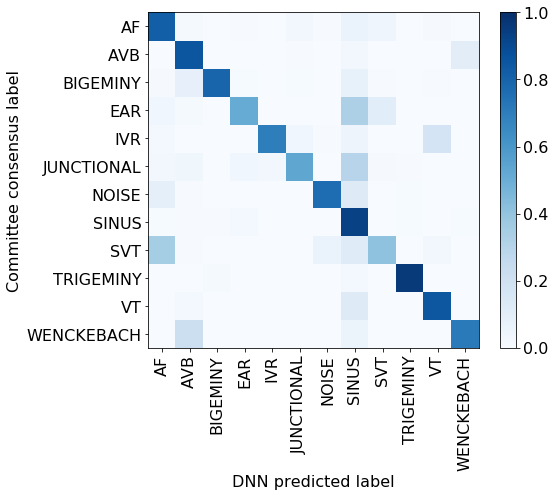

In [20]:
cm = skm.confusion_matrix(np.argmax(committee_labels, axis=2).ravel(),
                      np.argmax(probs, axis=2).ravel())
plot_confusions(cm, "DNN predicted label", "model_confusions.pdf")

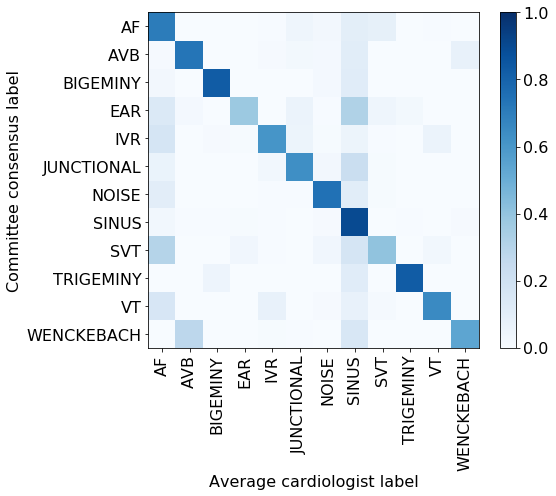

In [21]:
h_cm = skm.confusion_matrix(np.argmax(rep_comm, axis=2).ravel(), np.argmax(rev_labels, axis=2).ravel())
plot_confusions(h_cm, "Average cardiologist label", "human_confusions.pdf")

In [20]:
vt_class_idx = preproc.class_to_int["VT"]
vt_idx = np.where(np.any(np.argmax(committee_labels, axis=2) == vt_class_idx, axis=1))[0]

In [21]:
model_vt_idx = np.where(np.any(np.argmax(probs, axis=2) == vt_class_idx, axis=1))[0]

In [38]:
missed = list(set(model_vt_idx).difference(set(vt_idx)))
for m in missed:
    print np.argmax(committee_labels, axis=2)[m, :], np.argmax(probs,axis=2)[m,:]

[0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0] [ 0  0  0  0  0  0  0  0 10 10  0 10 10 10 10  0  0  0  0  0  0  0  0]
[7 7 7 7 7 7 7 4 4 4 4 4 7 7 7 7 7 7 7 7 7 7 7] [ 7  7  7  7  7  7  7 10 10  4  4  4  7  7  7  7  7  7  7  7  7  7  7]
[7 7 7 7 7 7 7 7 4 4 4 4 7 7 7 7 7 7 7 7 7 7 7] [ 7  7  7  7  7  7  7  4  4  4  4 10 10  7  7  7  7  7  7  7  7  7  7]
[7 7 7 7 7 7 7 7 7 7 4 4 6 6 6 6 4 4 4 4 4 4 4] [ 7  7  7  7  7  7  7  7  7  7 10  6  6  6  6  6  4  4  4  4  5  5  5]
[7 7 7 7 7 7 7 7 4 4 4 4 4 4 7 7 7 7 7 7 7 7 7] [ 7  7  7  7  7  7  7  7 10 10 10 10 10 10  7  7  7  7  7  7  7  7  7]
[5 5 5 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5] [ 7  7  7  7  7  7 10 10 10 10 10 10 10 10 10 10  4  7  7  7  7  7  7]
[7 7 7 7 7 7 7 7 7 7 7 4 4 7 7 7 7 7 7 7 7 7 7] [ 7  7  7  7  7  7  2  2  7  7 10 10 10  7  7  7  7  7  7  2  2  2  2]
[0 0 0 0 0 0 4 4 4 0 0 0 4 4 4 0 0 0 0 0 0 0 0] [ 0  0  0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
[5 5 5 5 5 5 5 5 5 5 5 5 7 7 7 7 5 5 5 5 5 7 7] 

In [35]:
print preproc.int_to_class

{0: u'AF', 1: u'AVB', 2: u'BIGEMINY', 3: u'EAR', 4: u'IVR', 5: u'JUNCTIONAL', 6: u'NOISE', 7: u'SINUS', 8: u'SVT', 9: u'TRIGEMINY', 10: u'VT', 11: u'WENCKEBACH'}


In [ ]:
10 IVR, 3 SVT, 3 AFIB, 1 JUNCTIONAL
